# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, MaxPooling1D, Activation, AveragePooling1D, BatchNormalization, Flatten, Dropout, SpatialDropout1D, GRU, GlobalAveragePooling1D
from tensorflow.keras import Input

2024-12-10 17:07:28.770967: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-10 17:07:28.779276: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 17:07:28.813290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-10 17:07:28.813320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-10 17:07:28.815248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Análise e visualização de ativos

### Carrega Dados

In [3]:
yfin.pdr_override()

acoes=['B3SA3','PETR4','KLBN11']
peso_acoes=np.ones(len(acoes))*1/len(acoes)
# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(acoes)):
    acoes[i]=acoes[i]+".SA"

acoes.append('^BVSP') # inclui o índice ibovespa na ultima coluna

acoes_df = pd.DataFrame() 
for acao in acoes:
     acoes_df[acao] = data.DataReader(acao, start='2010-01-01')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(acoes)):
    acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('.SA', '')})

#renomeia o índice IBOVESPA para IBOV   
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})
                           
#soma todos os valores nulos
acoes_df.isnull().sum()

#Verifica como está o shape do dataframe
acoes_df.shape
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3710, 4)

<Axes: ylabel='Date'>

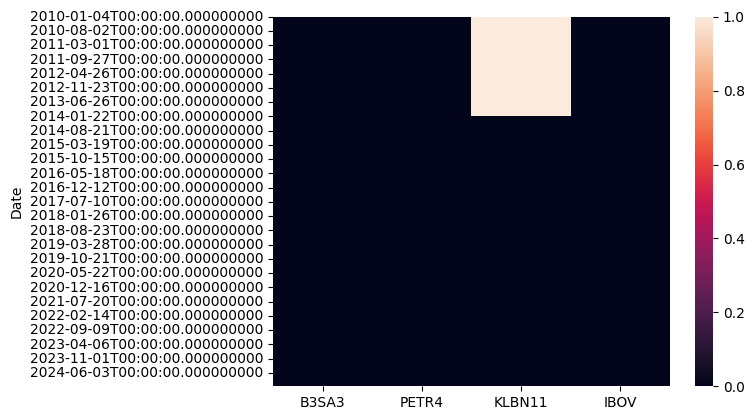

In [4]:
sns.heatmap(acoes_df.isnull())

In [5]:
#apaga registros nulos
acoes_df.dropna(inplace=True)
acoes_df.to_csv('acoes.csv')
acoes_df

B3SA3      PETR4     KLBN11           IBOV
Date                                                      
2014-01-23   3.250000  15.470000  10.676363   48321.000000
2014-01-24   3.233333  15.100000  10.676363   47787.000000
2014-01-27   3.300000  15.110000  10.676363   47701.000000
2014-01-28   3.280000  15.050000  11.441818   47841.000000
2014-01-29   3.170000  14.800000  11.227272   47557.000000
...               ...        ...        ...            ...
2024-12-04   9.570000  39.250000  23.250000  126087.000000
2024-12-05   9.780000  39.639999  23.230000  127858.000000
2024-12-06   9.930000  39.029999  23.090000  125946.000000
2024-12-09  10.000000  40.040001  23.379999  127210.000000
2024-12-10  10.120000  40.240002  22.990000  128153.710938

[2700 rows x 4 columns]

In [14]:
def labelling_method(close_price_list):
    window_size = 11  # Tamanho da janela deslizante
    number_of_days = len(close_price_list)  # Total de dias no arquivo
    labels = []  # Lista para armazenar os rótulos
    
    for counter_row in range(number_of_days):
        if counter_row >= window_size:
            # Define os índices da janela
            window_begin_index = counter_row - window_size
            window_end_index = counter_row - 1
            window_middle_index = (window_begin_index + window_end_index) // 2

            # Inicializa variáveis de máximo e mínimo
            min_price = float('inf')
            max_price = float('-inf')
            min_index = -1
            max_index = -1

            # Percorre a janela para identificar máximos e mínimos
            for i in range(window_begin_index, window_end_index + 1):
                price = close_price_list[i]
                if price < min_price:
                    min_price = price
                    min_index = i
                if price > max_price:
                    max_price = price
                    max_index = i

            # Rotula o dia central
            if max_index == window_middle_index:
                labels.append("SELL")
            elif min_index == window_middle_index:
                labels.append("BUY")
            else:
                labels.append("HOLD")
        else:
            # Não é possível rotular dias antes de preencher a janela
            labels.append('HOLD')

    return labels

# Exemplo de uso
close_price_list = acoes_df['B3SA3'].values
labels = labelling_method(close_price_list)
for day, label in enumerate(labels):
    print(f"Dia {day + 1}: {label}")

Dia 1: HOLD
Dia 2: HOLD
Dia 3: HOLD
Dia 4: HOLD
Dia 5: HOLD
Dia 6: HOLD
Dia 7: HOLD
Dia 8: HOLD
Dia 9: HOLD
Dia 10: HOLD
Dia 11: HOLD
Dia 12: HOLD
Dia 13: HOLD
Dia 14: BUY
Dia 15: HOLD
Dia 16: HOLD
Dia 17: SELL
Dia 18: HOLD
Dia 19: HOLD
Dia 20: HOLD
Dia 21: HOLD
Dia 22: BUY
Dia 23: HOLD
Dia 24: HOLD
Dia 25: HOLD
Dia 26: HOLD
Dia 27: HOLD
Dia 28: HOLD
Dia 29: HOLD
Dia 30: HOLD
Dia 31: HOLD
Dia 32: HOLD
Dia 33: HOLD
Dia 34: HOLD
Dia 35: HOLD
Dia 36: SELL
Dia 37: HOLD
Dia 38: HOLD
Dia 39: HOLD
Dia 40: HOLD
Dia 41: BUY
Dia 42: HOLD
Dia 43: HOLD
Dia 44: HOLD
Dia 45: HOLD
Dia 46: HOLD
Dia 47: HOLD
Dia 48: HOLD
Dia 49: BUY
Dia 50: HOLD
Dia 51: HOLD
Dia 52: HOLD
Dia 53: HOLD
Dia 54: HOLD
Dia 55: HOLD
Dia 56: HOLD
Dia 57: HOLD
Dia 58: HOLD
Dia 59: SELL
Dia 60: HOLD
Dia 61: HOLD
Dia 62: HOLD
Dia 63: BUY
Dia 64: HOLD
Dia 65: HOLD
Dia 66: SELL
Dia 67: HOLD
Dia 68: HOLD
Dia 69: HOLD
Dia 70: BUY
Dia 71: HOLD
Dia 72: HOLD
Dia 73: HOLD
Dia 74: HOLD
Dia 75: HOLD
Dia 76: SELL
Dia 77: HOLD
Dia 78: BUY
Di

array([ 3.25      ,  3.23333311,  3.29999995, ...,  9.93000031,
       10.        , 10.11999989])

### Visualização dos dados 

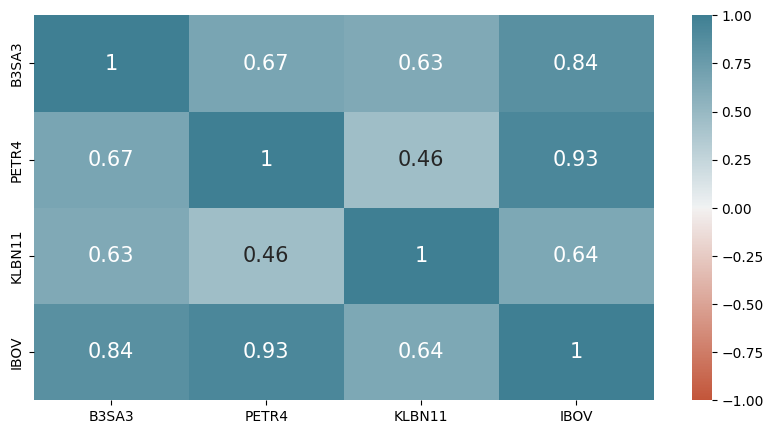

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=acoes_df.columns
corrmat = acoes_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [7]:
# Normaliza os dados
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [8]:
acoes_df_normalized

B3SA3     PETR4    KLBN11      IBOV
Date                                              
2014-01-23  1.000000  1.000000  1.000000  1.000000
2014-01-24  0.994872  0.976083  1.000000  0.988949
2014-01-27  1.015385  0.976729  1.000000  0.987169
2014-01-28  1.009231  0.972851  1.071696  0.990066
2014-01-29  0.975385  0.956690  1.051601  0.984189
...              ...       ...       ...       ...
2024-11-28  2.815384  2.494505  2.033464  2.578796
2024-11-29  2.849231  2.514544  2.080296  2.600691
2024-12-02  2.883077  2.530705  2.095283  2.591751
2024-12-03  2.910769  2.553329  2.121509  2.610439
2024-12-04  2.916923  2.558500  2.153355  2.615658

[2696 rows x 4 columns]

In [9]:
#%% Carregando dados
acoes_df=pd.read_csv('acoes.csv')
acoes_df['Date']=pd.to_datetime(acoes_df['Date'])
acoes_df=acoes_df.set_index('Date')
for col in acoes_df.columns:
    acoes_df[col]=acoes_df[col].astype('float32')

In [10]:
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [11]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for acoes in acoes_df.columns:
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=acoes_df_normalized.index, y=acoes_df_normalized[acoes], mode='lines', name=f'Preço do {acoes}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [12]:
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})


In [13]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import plotly.graph_objects as go

# Define o código de ticker da ação
ticker = "^BVSP"
ticker = "B3SA3"


if ticker!="^BVSP":
    ticker=ticker+".SA"

# Obtém os dados históricos da ação
df = data.DataReader(ticker, start='2015-01-01')



[*********************100%%**********************]  1 of 1 completed


In [14]:
scaler = MinMaxScaler()
y=scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Function to compute Simple Moving Average (SMA)
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to compute Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return upper_band, lower_band

df['upper_band_bollinger'],df['lower_band_bollinger']=calculate_bollinger_bands(df)
# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()
df['MA111*2'] = df['Close'].rolling(window=111).mean() * 2
df['MA350*2'] = df['Close'].rolling(window=350).mean() * 2


# Calculate RSI (14-period)
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate MACD (12, 26, 9)
df['MACD'], df['Signal'] = calculate_macd(df, short_window=12, long_window=26, signal_window=9)


In [15]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA111*2'], mode='lines', name='MA111*2'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA350*2'], mode='lines', name='MA350*2'))

if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [16]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['upper_band_bollinger'], mode='lines', name='upper band bollinger'))
fig.add_trace(go.Scatter(x=df.index, y=df['lower_band_bollinger'], mode='lines', name='lower band bollinger'))


if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [17]:

# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variation'] = ((df['Close'] - df['Close'].shift(+1)) / df['Close'])*100
#pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100


# Thresholds for variation classification
positive_threshold = 0.03
negative_threshold = -0.03

# Create a new column for classified variation
df['Classification'] = df['Variation'].apply(lambda x: 
                                            1 if x > positive_threshold else (
                                                -1 if x < negative_threshold else 0))

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df


Date      Open      High       Low     Close  Adj Close    Volume  \
0    2015-01-02  3.270000  3.270000  3.150000  3.170000   2.187124  21734100   
1    2015-01-05  3.143333  3.153333  3.056666  3.083333   2.127328  34790100   
2    2015-01-06  3.066666  3.113333  3.033333  3.113333   2.148027  49214700   
3    2015-01-07  3.133333  3.283333  3.126666  3.236666   2.233120  24006600   
4    2015-01-08  3.296666  3.300000  3.190000  3.193333   2.203223  22967700   
...         ...       ...       ...       ...       ...        ...       ...   
2466 2024-11-28  9.770000  9.820000  9.150000  9.150000   9.150000  65340600   
2467 2024-11-29  9.200000  9.340000  8.990000  9.260000   9.260000  81908200   
2468 2024-12-02  9.200000  9.420000  9.140000  9.370000   9.370000  78340300   
2469 2024-12-03  9.400000  9.490000  9.310000  9.460000   9.460000  39449100   
2470 2024-12-04  9.410000  9.530000  9.400000  9.490000   9.490000   6640300   

      upper_band_bollinger  lower_band_bollinger      EMA9  ...    MA350*2  \
0                 0.000000              0.000000  3.170000  ...   0.000000   
1                 0.000000              0.000000  3.121852  ...   0.000000   
2                 0.000000              0.000000  3.118360  ...   0.000000   
3                 0.000000              0.000000  3.158437  ...   0.000000   
4                 0.000000              0.000000  3.168818  ...   0.000000   
...                    ...                   ...       ...  ...        ...   
2466             11.132040              9.405960  9.889304  ...  24.396800   
2467             11.131018              9.254982  9.763443  ...  24.369257   
2468             11.114188              9.146813  9.684754  ...  24.343200   
2469             11.099821              9.065179  9.639804  ...  24.315829   
2470             10.994728              9.033272  9.609843  ...  24.286857   

         RSI_14      MACD    Signal  Variation  Classification  weekday  day  \
0      0.000000  0.000000  0.000000   0.000000               0        5    2   
1      0.000000 -0.006914 -0.001383  -2.810824              -1        1    5   
2      0.000000 -0.009858 -0.003078   0.963597               1        2    6   
3      0.000000 -0.002215 -0.002905   3.810494               1        3    7   
4      0.000000  0.000343 -0.002256  -1.356985              -1        4    8   
...         ...       ...       ...        ...             ...      ...  ...   
2466  22.826146 -0.306008 -0.241186  -6.666674              -1        4   28   
2467  24.199348 -0.341127 -0.261174   1.187912               1        5   29   
2468  31.349241 -0.355980 -0.280135   1.173956               1        1    2   
2469  35.772395 -0.356380 -0.295384   0.951376               1        2    3   
2470  32.478655 -0.350239 -0.306355   0.316119               1        3    4   

      month  quarter  
0         1        1  
1         1        1  
2         1        1  
3         1        1  
4         1        1  
...     ...      ...  
2466     11        4  
2467     11        4  
2468     12        4  
2469     12        4  
2470     12        4  

[2471 rows x 25 columns]

## Data preprocessing to stock forecast

### Pré-processamento dos dados para predição 

In [18]:
ticker

'B3SA3.SA'

In [19]:
# Pré-processamento dos dados
acoes_df.reset_index(inplace=True)
#ticker='IBOV'
if 'SA' in ticker:
    ticker=ticker[:-3]
    
acoes_df = acoes_df[['Date', ticker]]
acoes_df.columns = ['ds', 'y']

In [20]:
# scale the data - normalization
acoes_df_norm=acoes_df.copy()
scaler = MinMaxScaler()
acoes_df_norm['y'] = scaler.fit_transform(acoes_df['y'].values.reshape(-1,1))

In [21]:
features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']
acoes_df = df[['Close']+features_indicators]  
acoes_df_normalized = acoes_df / acoes_df.max().values
acoes_df_normalized.describe()
acoes_df['ds']=df['Date']

/tmp/ipykernel_19945/925237688.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
[feature.split('_') for feature in features_indicators]

[['EMA9'],
 ['EMA20'],
 ['EMA50'],
 ['EMA100'],
 ['EMA200'],
 ['RSI', '14'],
 ['MACD'],
 ['upper', 'band', 'bollinger'],
 ['lower', 'band', 'bollinger']]

In [23]:
def comput_features(data_array, lookback = 1, features_indicators=[]):
    """_summary_

    Args:
        data_array (_type_): transformed dat in scaler 
        lookback (int, optional): _description_. Defaults to 1.
        features_indicators (list, optional): _description_. Defaults to [].

    Returns:
        _type_: _description_
    """
    #df_=pd.DataFrame(data=scaler.inverse_transform(data_array.reshape(-1,1)),columns=['Close'])
    df_=pd.DataFrame(data=data_array.reshape(-1,1),columns=['Close'])


    if  True in ['bollinger' in feature.split('_') for feature in features_indicators]:
        df_['upper_band_bollinger'],df_['lower_band_bollinger']=calculate_bollinger_bands(df_)
    # Calcula as EMAs de 9 e 20 períodos
    if 'EMA9' in features_indicators:
        df_['EMA9'] = df_['Close'].ewm(span=9).mean()
    if 'EMA20' in features_indicators:   
        df_['EMA20'] = df_['Close'].ewm(span=20).mean()
    if 'EMA50' in features_indicators: 
        df_['EMA50'] = df_['Close'].ewm(span=50).mean()
    if 'EMA100' in features_indicators: 
        df_['EMA100'] = df_['Close'].ewm(span=100).mean()
    if 'EMA200' in features_indicators: 
        df_['EMA200'] = df_['Close'].ewm(span=200).mean()
    if 'MA111' in features_indicators: 
        df_['MA111'] = df_['Close'].rolling(window=111).mean()
    if 'MA350' in features_indicators: 
        df_['MA350'] = df_['Close'].rolling(window=350).mean() 
    if 'RSI_14' in features_indicators: 
        # Calculate RSI (14-period)
        df_['RSI_14'] = calculate_rsi(df, window=14)
    if 'MACD' in features_indicators: 
        # Calculate MACD (12, 26, 9)
        df_['MACD'], df_['Signal'] = calculate_macd(df_, short_window=12, long_window=26, signal_window=9)
    
    df_.iloc[:]= np.nan_to_num(df_.values)
    
    #return  df_[['Close']+features_indicators].iloc[-lookback:,:].values.reshape(1,-1)
    X_features=np.concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1)

    #for columns in df_.columns:
    #    df_[columns]= scaler.transform(df_[columns].values.reshape(-1,1))
    #X_features=scaler.transformnp(concatenate([df_['Close'].values[-lookback:],df_[features_indicators].values[-1]]).reshape(1, -1))
    return X_features

features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200',
                     'MA111', 'MA350',
                     'RSI_14', 'MACD','upper_band_bollinger', 'lower_band_bollinger']

features_indicators=['EMA9', 'EMA20', 'EMA50','EMA100', 'EMA200', 
                     'MA111', 'MA350',
                     'MACD','upper_band_bollinger', 'lower_band_bollinger']
#df.loc[:,['Close']+features_indicators]=df_.loc[:,['Close']+features_indicators]
#features_indicators=[]

In [24]:
df_norm=df.copy()
df_norm['Close']=scaler.transform(df['Close'].values.reshape(-1,1))

In [25]:
df_norm

Date      Open      High       Low     Close  Adj Close    Volume  \
0    2015-01-02  3.270000  3.270000  3.150000  0.011779   2.187124  21734100   
1    2015-01-05  3.143333  3.153333  3.056666  0.007340   2.127328  34790100   
2    2015-01-06  3.066666  3.113333  3.033333  0.008877   2.148027  49214700   
3    2015-01-07  3.133333  3.283333  3.126666  0.015193   2.233120  24006600   
4    2015-01-08  3.296666  3.300000  3.190000  0.012974   2.203223  22967700   
...         ...       ...       ...       ...       ...        ...       ...   
2466 2024-11-28  9.770000  9.820000  9.150000  0.318027   9.150000  65340600   
2467 2024-11-29  9.200000  9.340000  8.990000  0.323660   9.260000  81908200   
2468 2024-12-02  9.200000  9.420000  9.140000  0.329293   9.370000  78340300   
2469 2024-12-03  9.400000  9.490000  9.310000  0.333902   9.460000  39449100   
2470 2024-12-04  9.410000  9.530000  9.400000  0.335439   9.490000   6640300   

      upper_band_bollinger  lower_band_bollinger      EMA9  ...    MA350*2  \
0                 0.000000              0.000000  3.170000  ...   0.000000   
1                 0.000000              0.000000  3.121852  ...   0.000000   
2                 0.000000              0.000000  3.118360  ...   0.000000   
3                 0.000000              0.000000  3.158437  ...   0.000000   
4                 0.000000              0.000000  3.168818  ...   0.000000   
...                    ...                   ...       ...  ...        ...   
2466             11.132040              9.405960  9.889304  ...  24.396800   
2467             11.131018              9.254982  9.763443  ...  24.369257   
2468             11.114188              9.146813  9.684754  ...  24.343200   
2469             11.099821              9.065179  9.639804  ...  24.315829   
2470             10.994728              9.033272  9.609843  ...  24.286857   

         RSI_14      MACD    Signal  Variation  Classification  weekday  day  \
0      0.000000  0.000000  0.000000   0.000000               0        5    2   
1      0.000000 -0.006914 -0.001383  -2.810824              -1        1    5   
2      0.000000 -0.009858 -0.003078   0.963597               1        2    6   
3      0.000000 -0.002215 -0.002905   3.810494               1        3    7   
4      0.000000  0.000343 -0.002256  -1.356985              -1        4    8   
...         ...       ...       ...        ...             ...      ...  ...   
2466  22.826146 -0.306008 -0.241186  -6.666674              -1        4   28   
2467  24.199348 -0.341127 -0.261174   1.187912               1        5   29   
2468  31.349241 -0.355980 -0.280135   1.173956               1        1    2   
2469  35.772395 -0.356380 -0.295384   0.951376               1        2    3   
2470  32.478655 -0.350239 -0.306355   0.316119               1        3    4   

      month  quarter  
0         1        1  
1         1        1  
2         1        1  
3         1        1  
4         1        1  
...     ...      ...  
2466     11        4  
2467     11        4  
2468     12        4  
2469     12        4  
2470     12        4  

[2471 rows x 25 columns]

In [26]:
#lookback = 23  # number of past days used to predict the future value
lookback = 23  # number of past days used to predict the future value
pred_days = 1  # number of future days to predict
def windowing(data, features_indicators):
    X = []
    y = []
    x_time = []
    for win in np.arange(lookback,len(data),1):
        #X += [data[['Close']+features_indicators].values[win-lookback:win]]
        X_inputs=comput_features(data['Close'].values[:win],lookback, features_indicators).reshape(1,-1)
        X +=[X_inputs]
        #X +=[np.concatenate([data['Close'].values[win-lookback:win],data[features_indicators].values[win]])]
        #X +=[data['Close'].values[win-lookback:win]]
        y += [data[['Close']].values[win:win+pred_days]]
    


    data['Variation'] = ((data['Close'] - data['Close'].shift(+1)) / data['Close'])*100
    #pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

    X=np.array(X)
    X=np.nan_to_num(np.vstack(X.T).T)
    y_regression=np.vstack(y)
    return X, y_regression

X, y = windowing(df_norm,features_indicators)
date_time=df_norm['Date'][lookback:]
#date_time =date_time_old + datetime.timedelta(days=pred_days)

print("X shape",X.shape)
print("y regression shape",y.shape)
print("Last Date",date_time.values[-1])

X shape (2448, 33)
y regression shape (2448, 1)
Last Date 2024-12-04T00:00:00.000000000


In [27]:
#y=scaler.transform(y)
#for idx in range(len(features_indicators)+ lookback):
#    X[:,idx]=np.squeeze(scaler.transform(X[:,idx].reshape(-1,1)))

In [28]:
features_indicators

['EMA9',
 'EMA20',
 'EMA50',
 'EMA100',
 'EMA200',
 'MA111',
 'MA350',
 'MACD',
 'upper_band_bollinger',
 'lower_band_bollinger']

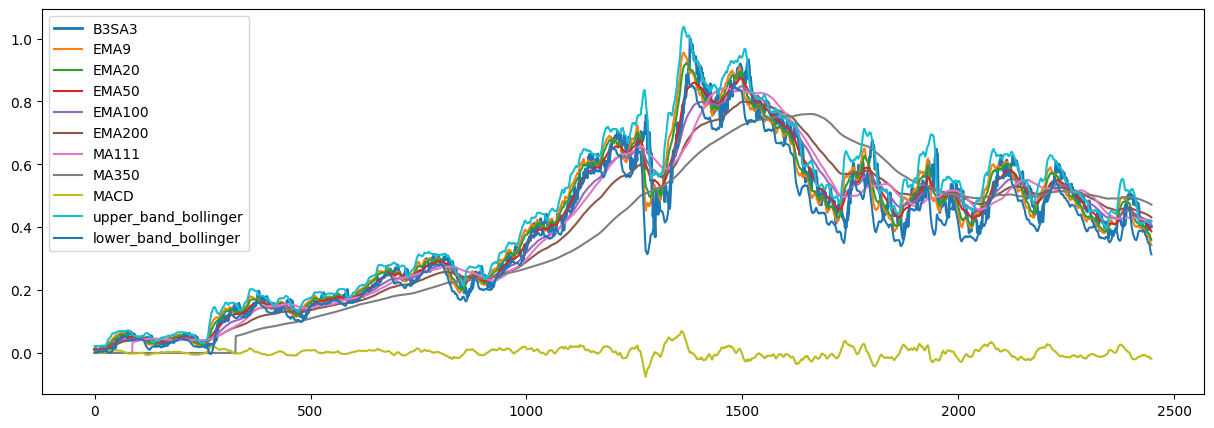

In [29]:
plt.figure(figsize=(15,5))
plt.plot(X[:,0],label=ticker,linewidth=2)
plt.plot(X[:,-len(features_indicators):])
plt.legend([ticker]+features_indicators)
plt.show()

In [30]:
# separa os dados em Treino e Teste
def split_data(X : np.array ,y : np.array, date_time : np.datetime64,factor=0.70):
    """Split the data in train validation or test

    Args:
        X (np.array): _description_
        y (np.array): _description_
        date_time (np.datetime64): _description_
        factor (float, optional): _description_. Defaults to 0.70.

    Returns:
        _type_: _description_
    """
    nits=round(len(X)*factor)

    X_train=X[:nits,:]

    nit_test= np.max(X_train.shape) -1
    X_test = X[nit_test:,:]

    y_train =y[:nits]
    y_test =y[nit_test:]

    T_train = date_time[:nits]
    T_test = date_time[nit_test:]
    
    return X_train,X_test, y_train, y_test, T_train, T_test

X_train,X_test, y_train, y_test, T_train, T_test=split_data(X,y,date_time, factor=0.85)

In [31]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=T_train ,y=np.squeeze(y_train), mode='lines',name="Dados de Treino"))
fig.add_trace(go.Scatter(x=T_test, y=np.squeeze(y_test), mode='lines',name="Dados de Teste"))
# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)
fig.show()

## Neural Networkt aproach

### Used Models

#### CNN_LSTM

In [32]:
from tensorflow.keras.initializers import RandomUniform, glorot_uniform, he_uniform

model_name= "CNN_LSTM"
np.random.seed(42)
def CNN_LSTM(data_input):
    # define model architecture
    model = Sequential()
   
    model.add(Conv1D(64, kernel_size=5, strides=2, activation='relu',input_shape=(X.shape[1],1), kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    #model.add(GRU(64, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    
    model.add(Dropout(0.2))
    model.add(Flatten())
    return model

def dense_layers(features, n_outputs=1, name=None):
    model=features

    # layer 2
    model.add( tf.keras.layers.Dense(32, kernel_initializer=he_uniform(seed=42), bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation(tf.keras.activations.relu))

    # layer 3 - Output Layer 
    model.add(tf.keras.layers.Dense(n_outputs))
    model.add(tf.keras.layers.Activation(tf.keras.activations.linear))
    return model

features = CNN_LSTM(X)
model_CNN_LSTM=dense_layers(features, n_outputs = pred_days)
model_CNN_LSTM._name=model_name
model_CNN_LSTM.summary()

Model: "CNN_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 64)            384       
                                                                 
 batch_normalization (Batch  (None, 15, 64)            256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 7, 64)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 64)             0         
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 32)                143

2024-12-04 13:31:51.268530: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


#### MultiLayer Perceptron

In [33]:
# Model name
model_name = "MLP"

# Input layer
input_data = Input(shape=(X.shape[1],))

# Dense layer 1 with batch normalization
dense1 = Dense(64)(input_data)
bn1 = BatchNormalization()(dense1)
activation1 = Activation('relu')(bn1)

# Dense layer 2 with batch normalization and dropout
dense2 = Dense(128)(activation1)
bn2 = BatchNormalization()(dense2)
activation2 = Activation('relu')(bn2)
dropout2 = Dropout(0.2)(activation2)

# Output layer
output = Dense(1, activation='linear')(dropout2)

# Create the model
model_MLP = Model(inputs=input_data, outputs=output)
model_MLP._name = model_name

# Print model summary
model_MLP.summary()

Model: "MLP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense_2 (Dense)             (None, 64)                2176      
                                                                 
 batch_normalization_2 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                              

#### Long Short-Term Memory (LSTM) 

In [34]:
model_name= "LSTM"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
lstm_output  = LSTM(64, return_sequences=False)(input_data)
bn_lstm = BatchNormalization()(lstm_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

#lstm_output2  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output2)

#lstm_output3  = LSTM(64, activation='relu', return_sequences=True)(Dropout_output)
#Dropout_output = Dropout(0.1)(lstm_output3)

#lstm_output  = LSTM(4, activation='tanh')(Dropout_output)
#Dropout_output = Dropout(0.2)(lstm_output)

#dense_output = Dense(32, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)

#dense_output = Dense(8, activation='relu')(Dropout_output)
#Dropout_output=Dropout(0.2)(dense_output)
# Camada de saída
output = Dense(1, activation='linear')(Dropout_output)

model_LSTM = Model(inputs=input_data, outputs=output)
model_LSTM._name = model_name
model_LSTM.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 33, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 batch_normalization_4 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                              

#### Long Short-Term Memory (GRU) 

In [35]:
model_name= "GRU"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

# Camada LSTM
GRU_output  = GRU(64)(input_data)

bn_lstm = BatchNormalization()(GRU_output)
activation_lstm = Activation('relu')(bn_lstm)
Dropout_output = Dropout(0.2)(activation_lstm)

output = Dense(pred_days, activation='linear')(Dropout_output)

model_GRU = Model(inputs=input_data, outputs=output)
model_GRU._name = model_name
model_GRU.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 33, 1)]           0         
                                                                 
 gru (GRU)                   (None, 64)                12864     
                                                                 
 batch_normalization_5 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                               

#### LSTM with Attention layer

In [36]:
# Define the Attention layer
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [37]:
model_name= "LSTM_AT"
# Camada de entrada
input_data = Input(shape=(X.shape[1],1))

LSTM_output = tf.keras.layers.LSTM(64, return_sequences=True)(input_data)

bn_lstm = BatchNormalization()(LSTM_output)
activation_lstm = Activation('relu')(bn_lstm)
X = Dropout(0.2)(activation_lstm)

x = Attention(64)(X)
x = tf.keras.layers.Dense(pred_days)(x)

model_LSTM_AT = tf.keras.Model(inputs=input_data, outputs=x)
model_LSTM_AT._name = model_name

model_LSTM_AT.summary()

Model: "LSTM_AT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 33, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 33, 64)            16896     
                                                                 
 batch_normalization_6 (Bat  (None, 33, 64)            256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 33, 64)            0         
                                                                 
 dropout_4 (Dropout)         (None, 33, 64)            0         
                                                                 
 attention (Attention)       (None, 64)                4225      
                                                           

### Hyperparams and trainnig

**Metrics and Loss Functions**  

In [38]:
from tensorflow.keras import backend as K

def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot - K.epsilon()) )

def NRMSE(y_true, y_pred): # normalized_root_mean_squared_error
    return 1-K.sqrt(K.mean(K.square(y_pred - y_true))) 

MSE= tf.keras.losses.mean_squared_error
MAE = tf.keras.losses.mean_absolute_error
MAPE = tf.keras.losses.mean_absolute_percentage_error

**Optimizers**  

In [39]:
def get_optimizer():
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=True, name="Adam")
    return optimizer1
    #optimizer2 = tf.keras.optimizers.RMSprop(learning_rate=0.05)

**Train options callbacks**  

In [40]:
# Avalia se está tendo avanção de desempenho no treinamento/validação e para caso não tenha avanço 
EarlyStopping=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10, verbose=1, mode="min", restore_best_weights=True,)

# verifica se está tendo avanço de desempenho durante o treinamento, caso não reduz integralmente o lr
reduceLr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 5, min_lr=1e-14,verbose=1)


checkpoint_filepath = './models_checkpoint/'
checkpoint_filepath =f'models/{model_name}_{ticker}_{lookback}_ex1'


def checkpoints(model_name):
    checkpoint_filepath =f'models/model_{model_name}_stock_{ticker}_lookback_{lookback}'
    csvLogger = tf.keras.callbacks.CSVLogger(checkpoint_filepath+'_history.csv', separator=',',append=True)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
    print("Training model :", checkpoint_filepath)

    return csvLogger, model_checkpoint_callback

### Models train

Training model : models/model_MLP_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: MLP
Epoch 1/200
 1/46 [..............................] - ETA: 32s - loss: 0.4969 - NRMSE: 0.2951
Epoch 1: val_loss improved from inf to 9.91041, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 23ms/step - loss: 0.7990 - NRMSE: 0.3928 - val_loss: 9.9104 - val_NRMSE: -2.0237 - lr: 0.0500
Epoch 2/200
27/46 [================>.............] - ETA: 0s - loss: 0.0732 - NRMSE: 0.7437
Epoch 2: val_loss improved from 9.91041 to 0.00788, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 1s 14ms/step - loss: 0.0524 - NRMSE: 0.7912 - val_loss: 0.0079 - val_NRMSE: 0.9172 - lr: 0.0500
Epoch 3/200
 1/46 [..............................] - ETA: 0s - loss: 0.0178 - NRMSE: 0.8666
Epoch 3: val_loss did not improve from 0.00788
46/46 [==============================] - 0s 2ms/step - loss: 0.0129 - NRMSE: 0.8909 - val_loss: 0.1282 - val_NRMSE: 0.6565 - lr: 0.0500
Epoch 4/200
29/46 [=================>............] - ETA: 0s - loss: 0.0082 - NRMSE: 0.9120
Epoch 4: val_loss did not improve from 0.00788
46/46 [==============================] - 0s 2ms/step - loss: 0.0097 - NRMSE: 0.9068 - val_loss: 0.0249 - val_NRMSE: 0.8509 - lr: 0.0500
Epoch 5/200
 1/46 [..............................] - ETA: 0s - loss: 0.0058 - NRMSE: 0.9236
Epoch 5: val_loss improved from 0.00788 to 0.00355, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 1s 13ms/step - loss: 0.0077 - NRMSE: 0.9170 - val_loss: 0.0035 - val_NRMSE: 0.9459 - lr: 0.0500
Epoch 6/200
 1/46 [..............................] - ETA: 0s - loss: 0.0179 - NRMSE: 0.8664
Epoch 6: val_loss did not improve from 0.00355
46/46 [==============================] - 0s 1ms/step - loss: 0.0066 - NRMSE: 0.9216 - val_loss: 0.0109 - val_NRMSE: 0.9068 - lr: 0.0500
Epoch 7/200
43/46 [===========================>..] - ETA: 0s - loss: 0.0058 - NRMSE: 0.9273
Epoch 7: val_loss did not improve from 0.00355
46/46 [==============================] - 0s 2ms/step - loss: 0.0062 - NRMSE: 0.9259 - val_loss: 0.0181 - val_NRMSE: 0.8877 - lr: 0.0500
Epoch 8/200
30/46 [==================>...........] - ETA: 0s - loss: 0.0087 - NRMSE: 0.9130
Epoch 8: val_loss did not improve from 0.00355
46/46 [==============================] - 0s 2ms/step - loss: 0.0083 - NRMSE: 0.9145 - val_loss: 0.0039 - val_NRMSE: 0.9429 - lr: 0.0500
Epoch 9/200
 1/46 [...................

INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 1s 13ms/step - loss: 0.0112 - NRMSE: 0.9022 - val_loss: 0.0022 - val_NRMSE: 0.9588 - lr: 0.0500
Epoch 10/200
 1/46 [..............................] - ETA: 0s - loss: 0.0036 - NRMSE: 0.9396
Epoch 10: val_loss did not improve from 0.00219
46/46 [==============================] - 0s 1ms/step - loss: 0.0118 - NRMSE: 0.8993 - val_loss: 0.0641 - val_NRMSE: 0.7997 - lr: 0.0500
Epoch 11/200
 1/46 [..............................] - ETA: 0s - loss: 0.0151 - NRMSE: 0.8771
Epoch 11: val_loss did not improve from 0.00219
46/46 [==============================] - 0s 1ms/step - loss: 0.0087 - NRMSE: 0.9128 - val_loss: 0.0025 - val_NRMSE: 0.9531 - lr: 0.0500
Epoch 12/200
 1/46 [..............................] - ETA: 0s - loss: 0.0025 - NRMSE: 0.9500
Epoch 12: val_loss did not improve from 0.00219
46/46 [==============================] - 0s 1ms/step - loss: 0.0059 - NRMSE: 0.9260 - val_loss: 0.0163 - val_NRMSE: 0.8826 - lr: 0.0500
Epoch 13/200
 1/46 [............

INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 1s 12ms/step - loss: 0.0048 - NRMSE: 0.9341 - val_loss: 0.0022 - val_NRMSE: 0.9559 - lr: 0.0100
Epoch 16/200
 1/46 [..............................] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9626
Epoch 16: val_loss improved from 0.00216 to 0.00215, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 1s 12ms/step - loss: 0.0029 - NRMSE: 0.9476 - val_loss: 0.0022 - val_NRMSE: 0.9556 - lr: 0.0100
Epoch 17/200
 1/46 [..............................] - ETA: 0s - loss: 0.0036 - NRMSE: 0.9402
Epoch 17: val_loss improved from 0.00215 to 0.00121, saving model to models/model_MLP_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 1s 18ms/step - loss: 0.0047 - NRMSE: 0.9348 - val_loss: 0.0012 - val_NRMSE: 0.9664 - lr: 0.0100
Epoch 18/200
 1/46 [..............................] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9629
Epoch 18: val_loss did not improve from 0.00121
46/46 [==============================] - 0s 1ms/step - loss: 0.0036 - NRMSE: 0.9425 - val_loss: 0.0013 - val_NRMSE: 0.9654 - lr: 0.0100
Epoch 19/200
 1/46 [..............................] - ETA: 0s - loss: 0.0010 - NRMSE: 0.9678
Epoch 19: val_loss did not improve from 0.00121
46/46 [==============================] - 0s 1ms/step - loss: 0.0040 - NRMSE: 0.9397 - val_loss: 0.0022 - val_NRMSE: 0.9592 - lr: 0.0100
Epoch 20/200
 1/46 [..............................] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9607
Epoch 20: val_loss did not improve from 0.00121
46/46 [==============================] - 0s 2ms/step - loss: 0.0050 - NRMSE: 0.9338 - val_loss: 0.0019 - val_NRMSE: 0.9590 - lr: 0.0100
Epoch 21/200
 1/46 [............

INFO:tensorflow:Assets written to: models/model_MLP_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 1s 12ms/step - loss: 0.0031 - NRMSE: 0.9463 - val_loss: 0.0010 - val_NRMSE: 0.9694 - lr: 0.0100
Epoch 23/200
 1/46 [..............................] - ETA: 0s - loss: 0.0018 - NRMSE: 0.9578
Epoch 23: val_loss did not improve from 0.00101
46/46 [==============================] - 0s 1ms/step - loss: 0.0035 - NRMSE: 0.9434 - val_loss: 0.0014 - val_NRMSE: 0.9645 - lr: 0.0100
Epoch 24/200
 1/46 [..............................] - ETA: 0s - loss: 0.0032 - NRMSE: 0.9432
Epoch 24: val_loss did not improve from 0.00101
46/46 [==============================] - 0s 1ms/step - loss: 0.0040 - NRMSE: 0.9421 - val_loss: 0.0022 - val_NRMSE: 0.9592 - lr: 0.0100
Epoch 25/200
 1/46 [..............................] - ETA: 0s - loss: 0.0012 - NRMSE: 0.9659
Epoch 25: val_loss did not improve from 0.00101
46/46 [==============================] - 0s 1ms/step - loss: 0.0049 - NRMSE: 0.9356 - val_loss: 0.0014 - val_NRMSE: 0.9645 - lr: 0.0100
Epoch 26/200
 1/46 [............

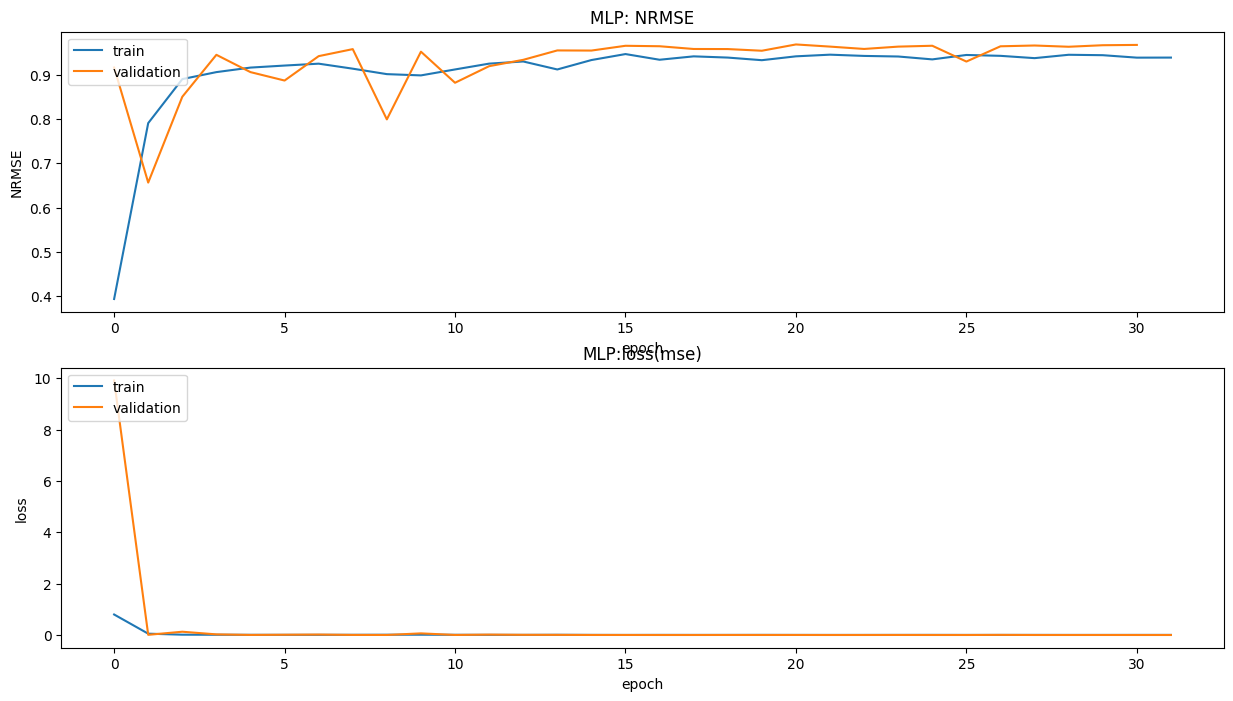

Training model : models/model_GRU_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: GRU
Epoch 1/200
41/46 [=========================>....] - ETA: 0s - loss: 0.2194 - NRMSE: 0.6747
Epoch 1: val_loss improved from inf to 0.72148, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 3s 42ms/step - loss: 0.1993 - NRMSE: 0.6970 - val_loss: 0.7215 - val_NRMSE: 0.1594 - lr: 0.0500
Epoch 2/200
37/46 [=======================>......] - ETA: 0s - loss: 0.0105 - NRMSE: 0.9013
Epoch 2: val_loss improved from 0.72148 to 0.25098, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 44ms/step - loss: 0.0098 - NRMSE: 0.9047 - val_loss: 0.2510 - val_NRMSE: 0.5128 - lr: 0.0500
Epoch 3/200
46/46 [==============================] - ETA: 0s - loss: 0.0067 - NRMSE: 0.9212
Epoch 3: val_loss improved from 0.25098 to 0.14558, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 37ms/step - loss: 0.0067 - NRMSE: 0.9212 - val_loss: 0.1456 - val_NRMSE: 0.6366 - lr: 0.0500
Epoch 4/200
42/46 [==========================>...] - ETA: 0s - loss: 0.0067 - NRMSE: 0.9222
Epoch 4: val_loss improved from 0.14558 to 0.11816, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 45ms/step - loss: 0.0065 - NRMSE: 0.9235 - val_loss: 0.1182 - val_NRMSE: 0.6768 - lr: 0.0500
Epoch 5/200
39/46 [========================>.....] - ETA: 0s - loss: 0.0050 - NRMSE: 0.9327
Epoch 5: val_loss improved from 0.11816 to 0.06159, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 36ms/step - loss: 0.0051 - NRMSE: 0.9314 - val_loss: 0.0616 - val_NRMSE: 0.7796 - lr: 0.0500
Epoch 6/200
37/46 [=======================>......] - ETA: 0s - loss: 0.0058 - NRMSE: 0.9284
Epoch 6: val_loss improved from 0.06159 to 0.05466, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 34ms/step - loss: 0.0058 - NRMSE: 0.9275 - val_loss: 0.0547 - val_NRMSE: 0.7942 - lr: 0.0500
Epoch 7/200
38/46 [=======================>......] - ETA: 0s - loss: 0.0058 - NRMSE: 0.9285
Epoch 7: val_loss improved from 0.05466 to 0.04960, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 42ms/step - loss: 0.0060 - NRMSE: 0.9267 - val_loss: 0.0496 - val_NRMSE: 0.8050 - lr: 0.0500
Epoch 8/200
38/46 [=======================>......] - ETA: 0s - loss: 0.0048 - NRMSE: 0.9336
Epoch 8: val_loss improved from 0.04960 to 0.03351, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 35ms/step - loss: 0.0048 - NRMSE: 0.9334 - val_loss: 0.0335 - val_NRMSE: 0.8462 - lr: 0.0500
Epoch 9/200
38/46 [=======================>......] - ETA: 0s - loss: 0.0061 - NRMSE: 0.9260
Epoch 9: val_loss improved from 0.03351 to 0.03159, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 35ms/step - loss: 0.0063 - NRMSE: 0.9249 - val_loss: 0.0316 - val_NRMSE: 0.8459 - lr: 0.0500
Epoch 10/200
39/46 [========================>.....] - ETA: 0s - loss: 0.0052 - NRMSE: 0.9309
Epoch 10: val_loss did not improve from 0.03159
46/46 [==============================] - 0s 7ms/step - loss: 0.0050 - NRMSE: 0.9327 - val_loss: 0.0487 - val_NRMSE: 0.7965 - lr: 0.0500
Epoch 11/200
46/46 [==============================] - ETA: 0s - loss: 0.0057 - NRMSE: 0.9292
Epoch 11: val_loss did not improve from 0.03159
46/46 [==============================] - 0s 7ms/step - loss: 0.0057 - NRMSE: 0.9292 - val_loss: 0.0623 - val_NRMSE: 0.7681 - lr: 0.0500
Epoch 12/200
39/46 [========================>.....] - ETA: 0s - loss: 0.0077 - NRMSE: 0.9183
Epoch 12: val_loss improved from 0.03159 to 0.00659, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 42ms/step - loss: 0.0072 - NRMSE: 0.9214 - val_loss: 0.0066 - val_NRMSE: 0.9345 - lr: 0.0500
Epoch 13/200
46/46 [==============================] - ETA: 0s - loss: 0.0050 - NRMSE: 0.9338
Epoch 13: val_loss improved from 0.00659 to 0.00640, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 38ms/step - loss: 0.0050 - NRMSE: 0.9338 - val_loss: 0.0064 - val_NRMSE: 0.9346 - lr: 0.0500
Epoch 14/200
46/46 [==============================] - ETA: 0s - loss: 0.0042 - NRMSE: 0.9382
Epoch 14: val_loss did not improve from 0.00640
46/46 [==============================] - 0s 7ms/step - loss: 0.0042 - NRMSE: 0.9382 - val_loss: 0.0099 - val_NRMSE: 0.9236 - lr: 0.0500
Epoch 15/200
44/46 [===========================>..] - ETA: 0s - loss: 0.0071 - NRMSE: 0.9226
Epoch 15: val_loss improved from 0.00640 to 0.00290, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 37ms/step - loss: 0.0070 - NRMSE: 0.9232 - val_loss: 0.0029 - val_NRMSE: 0.9502 - lr: 0.0500
Epoch 16/200
38/46 [=======================>......] - ETA: 0s - loss: 0.0062 - NRMSE: 0.9279
Epoch 16: val_loss did not improve from 0.00290
46/46 [==============================] - 0s 7ms/step - loss: 0.0062 - NRMSE: 0.9270 - val_loss: 0.0031 - val_NRMSE: 0.9479 - lr: 0.0500
Epoch 17/200
41/46 [=========================>....] - ETA: 0s - loss: 0.0048 - NRMSE: 0.9342
Epoch 17: val_loss did not improve from 0.00290
46/46 [==============================] - 0s 7ms/step - loss: 0.0049 - NRMSE: 0.9327 - val_loss: 0.0072 - val_NRMSE: 0.9292 - lr: 0.0500
Epoch 18/200
40/46 [=========================>....] - ETA: 0s - loss: 0.0048 - NRMSE: 0.9344
Epoch 18: val_loss did not improve from 0.00290
46/46 [==============================] - 0s 7ms/step - loss: 0.0047 - NRMSE: 0.9346 - val_loss: 0.0101 - val_NRMSE: 0.9055 - lr: 0.0500
Epoch 19/200
39/46 [============

INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 46ms/step - loss: 0.0040 - NRMSE: 0.9393 - val_loss: 0.0025 - val_NRMSE: 0.9534 - lr: 0.0100
Epoch 22/200
40/46 [=========================>....] - ETA: 0s - loss: 0.0037 - NRMSE: 0.9421
Epoch 22: val_loss improved from 0.00248 to 0.00137, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 35ms/step - loss: 0.0036 - NRMSE: 0.9423 - val_loss: 0.0014 - val_NRMSE: 0.9648 - lr: 0.0100
Epoch 23/200
40/46 [=========================>....] - ETA: 0s - loss: 0.0039 - NRMSE: 0.9418
Epoch 23: val_loss did not improve from 0.00137
46/46 [==============================] - 0s 7ms/step - loss: 0.0043 - NRMSE: 0.9389 - val_loss: 0.0016 - val_NRMSE: 0.9628 - lr: 0.0100
Epoch 24/200
39/46 [========================>.....] - ETA: 0s - loss: 0.0037 - NRMSE: 0.9417
Epoch 24: val_loss did not improve from 0.00137
46/46 [==============================] - 0s 7ms/step - loss: 0.0036 - NRMSE: 0.9415 - val_loss: 0.0053 - val_NRMSE: 0.9304 - lr: 0.0100
Epoch 25/200
40/46 [=========================>....] - ETA: 0s - loss: 0.0033 - NRMSE: 0.9447
Epoch 25: val_loss did not improve from 0.00137
46/46 [==============================] - 0s 7ms/step - loss: 0.0034 - NRMSE: 0.9442 - val_loss: 0.0016 - val_NRMSE: 0.9631 - lr: 0.0100
Epoch 26/200
41/46 [============

INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 38ms/step - loss: 0.0032 - NRMSE: 0.9457 - val_loss: 0.0013 - val_NRMSE: 0.9660 - lr: 0.0020
Epoch 29/200
42/46 [==========================>...] - ETA: 0s - loss: 0.0034 - NRMSE: 0.9446
Epoch 29: val_loss improved from 0.00128 to 0.00118, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 47ms/step - loss: 0.0037 - NRMSE: 0.9427 - val_loss: 0.0012 - val_NRMSE: 0.9671 - lr: 0.0020
Epoch 30/200
39/46 [========================>.....] - ETA: 0s - loss: 0.0033 - NRMSE: 0.9439
Epoch 30: val_loss improved from 0.00118 to 0.00117, saving model to models/model_GRU_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_GRU_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 39ms/step - loss: 0.0033 - NRMSE: 0.9441 - val_loss: 0.0012 - val_NRMSE: 0.9673 - lr: 0.0020
Epoch 31/200
43/46 [===========================>..] - ETA: 0s - loss: 0.0030 - NRMSE: 0.9475
Epoch 31: val_loss did not improve from 0.00117
46/46 [==============================] - 0s 8ms/step - loss: 0.0030 - NRMSE: 0.9475 - val_loss: 0.0012 - val_NRMSE: 0.9666 - lr: 0.0020
Epoch 32/200
39/46 [========================>.....] - ETA: 0s - loss: 0.0031 - NRMSE: 0.9468
Epoch 32: val_loss did not improve from 0.00117
46/46 [==============================] - 0s 7ms/step - loss: 0.0031 - NRMSE: 0.9465 - val_loss: 0.0013 - val_NRMSE: 0.9662 - lr: 0.0020
Epoch 33/200
38/46 [=======================>......] - ETA: 0s - loss: 0.0038 - NRMSE: 0.9420
Epoch 33: val_loss did not improve from 0.00117
46/46 [==============================] - 0s 7ms/step - loss: 0.0037 - NRMSE: 0.9425 - val_loss: 0.0016 - val_NRMSE: 0.9626 - lr: 0.0020
Epoch 34/200
41/46 [============

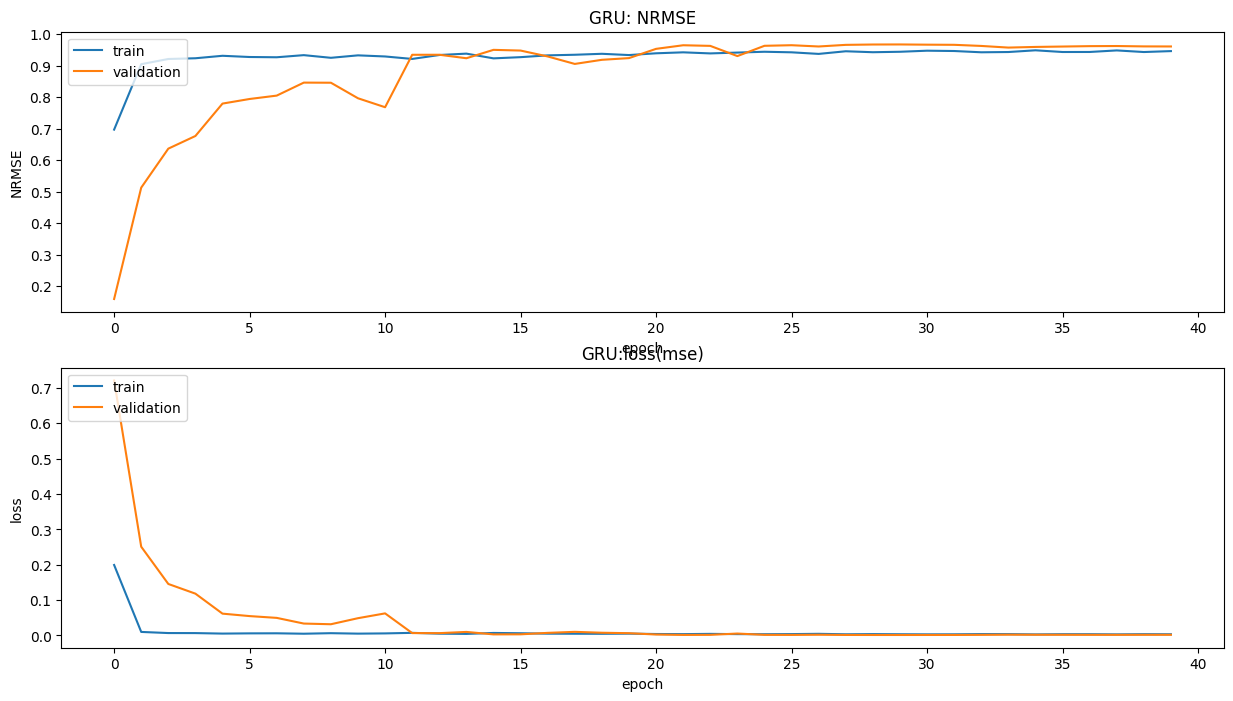

Training model : models/model_CNN_LSTM_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: CNN_LSTM
Epoch 1/200
37/46 [=======================>......] - ETA: 0s - loss: 0.1594 - NRMSE: 0.6851 
Epoch 1: val_loss improved from inf to 0.02899, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 29ms/step - loss: 0.1315 - NRMSE: 0.7284 - val_loss: 0.0290 - val_NRMSE: 0.8672 - lr: 0.0500
Epoch 2/200
31/46 [===================>..........] - ETA: 0s - loss: 0.0062 - NRMSE: 0.9244
Epoch 2: val_loss improved from 0.02899 to 0.00943, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 1s 16ms/step - loss: 0.0063 - NRMSE: 0.9244 - val_loss: 0.0094 - val_NRMSE: 0.9235 - lr: 0.0500
Epoch 3/200
32/46 [===================>..........] - ETA: 0s - loss: 0.0045 - NRMSE: 0.9375
Epoch 3: val_loss did not improve from 0.00943
46/46 [==============================] - 0s 2ms/step - loss: 0.0055 - NRMSE: 0.9320 - val_loss: 0.0457 - val_NRMSE: 0.8308 - lr: 0.0500
Epoch 4/200
41/46 [=========================>....] - ETA: 0s - loss: 0.0064 - NRMSE: 0.9293
Epoch 4: val_loss did not improve from 0.00943
46/46 [==============================] - 0s 4ms/step - loss: 0.0063 - NRMSE: 0.9303 - val_loss: 0.0164 - val_NRMSE: 0.8998 - lr: 0.0500
Epoch 5/200
41/46 [=========================>....] - ETA: 0s - loss: 0.0069 - NRMSE: 0.9254
Epoch 5: val_loss improved from 0.00943 to 0.00395, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 1s 17ms/step - loss: 0.0068 - NRMSE: 0.9263 - val_loss: 0.0039 - val_NRMSE: 0.9417 - lr: 0.0500
Epoch 6/200
35/46 [=====================>........] - ETA: 0s - loss: 0.0041 - NRMSE: 0.9409
Epoch 6: val_loss improved from 0.00395 to 0.00298, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 1s 14ms/step - loss: 0.0038 - NRMSE: 0.9427 - val_loss: 0.0030 - val_NRMSE: 0.9508 - lr: 0.0500
Epoch 7/200
36/46 [======================>.......] - ETA: 0s - loss: 0.0033 - NRMSE: 0.9476    
Epoch 7: val_loss did not improve from 0.00298
46/46 [==============================] - 0s 2ms/step - loss: 0.0036 - NRMSE: 0.9447 - val_loss: 0.0030 - val_NRMSE: 0.9502 - lr: 0.0500
Epoch 8/200
30/46 [==================>...........] - ETA: 0s - loss: 0.0047 - NRMSE: 0.9357    
Epoch 8: val_loss did not improve from 0.00298
46/46 [==============================] - 0s 2ms/step - loss: 0.0056 - NRMSE: 0.9316 - val_loss: 0.0057 - val_NRMSE: 0.9294 - lr: 0.0500
Epoch 9/200
34/46 [=====================>........] - ETA: 0s - loss: 0.0055 - NRMSE: 0.9329
Epoch 9: val_loss did not improve from 0.00298
46/46 [==============================] - 0s 2ms/step - loss: 0.0063 - NRMSE: 0.9280 - val_loss: 0.0093 - val_NRMSE: 0.9126 - lr: 0.0500
Epoch 10/200
31/46 [==========

INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 1s 14ms/step - loss: 0.0025 - NRMSE: 0.9549 - val_loss: 0.0018 - val_NRMSE: 0.9604 - lr: 0.0100
Epoch 13/200
37/46 [=======================>......] - ETA: 0s - loss: 0.0022 - NRMSE: 0.9557
Epoch 13: val_loss did not improve from 0.00177
46/46 [==============================] - 0s 2ms/step - loss: 0.0023 - NRMSE: 0.9547 - val_loss: 0.0018 - val_NRMSE: 0.9610 - lr: 0.0100
Epoch 14/200
39/46 [========================>.....] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9518    
Epoch 14: val_loss did not improve from 0.00177
46/46 [==============================] - 0s 2ms/step - loss: 0.0027 - NRMSE: 0.9521 - val_loss: 0.0022 - val_NRMSE: 0.9567 - lr: 0.0100
Epoch 15/200
38/46 [=======================>......] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9545
Epoch 15: val_loss improved from 0.00177 to 0.00139, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 1s 15ms/step - loss: 0.0026 - NRMSE: 0.9526 - val_loss: 0.0014 - val_NRMSE: 0.9653 - lr: 0.0100
Epoch 16/200
24/46 [==============>...............] - ETA: 0s - loss: 0.0024 - NRMSE: 0.9533
Epoch 16: val_loss did not improve from 0.00139
46/46 [==============================] - 0s 3ms/step - loss: 0.0020 - NRMSE: 0.9580 - val_loss: 0.0014 - val_NRMSE: 0.9651 - lr: 0.0100
Epoch 17/200
31/46 [===================>..........] - ETA: 0s - loss: 0.0025 - NRMSE: 0.9560
Epoch 17: val_loss did not improve from 0.00139
46/46 [==============================] - 0s 2ms/step - loss: 0.0026 - NRMSE: 0.9540 - val_loss: 0.0023 - val_NRMSE: 0.9551 - lr: 0.0100
Epoch 18/200
32/46 [===================>..........] - ETA: 0s - loss: 0.0020 - NRMSE: 0.9585
Epoch 18: val_loss did not improve from 0.00139
46/46 [==============================] - 0s 2ms/step - loss: 0.0021 - NRMSE: 0.9582 - val_loss: 0.0032 - val_NRMSE: 0.9528 - lr: 0.0100
Epoch 19/200
36/46 [============

INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 1s 19ms/step - loss: 0.0026 - NRMSE: 0.9519 - val_loss: 0.0011 - val_NRMSE: 0.9687 - lr: 0.0020
Epoch 22/200
38/46 [=======================>......] - ETA: 0s - loss: 0.0020 - NRMSE: 0.9583
Epoch 22: val_loss improved from 0.00111 to 0.00100, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 1s 13ms/step - loss: 0.0022 - NRMSE: 0.9560 - val_loss: 0.0010 - val_NRMSE: 0.9698 - lr: 0.0020
Epoch 23/200
34/46 [=====================>........] - ETA: 0s - loss: 0.0022 - NRMSE: 0.9560
Epoch 23: val_loss did not improve from 0.00100
46/46 [==============================] - 0s 2ms/step - loss: 0.0020 - NRMSE: 0.9577 - val_loss: 0.0012 - val_NRMSE: 0.9675 - lr: 0.0020
Epoch 24/200
38/46 [=======================>......] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9562
Epoch 24: val_loss improved from 0.00100 to 0.00086, saving model to models/model_CNN_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_CNN_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 1s 14ms/step - loss: 0.0023 - NRMSE: 0.9551 - val_loss: 8.6390e-04 - val_NRMSE: 0.9719 - lr: 0.0020
Epoch 25/200
33/46 [====================>.........] - ETA: 0s - loss: 0.0017 - NRMSE: 0.9617    
Epoch 25: val_loss did not improve from 0.00086
46/46 [==============================] - 0s 2ms/step - loss: 0.0017 - NRMSE: 0.9605 - val_loss: 0.0011 - val_NRMSE: 0.9694 - lr: 0.0020
Epoch 26/200
34/46 [=====================>........] - ETA: 0s - loss: 0.0018 - NRMSE: 0.9609    
Epoch 26: val_loss did not improve from 0.00086
46/46 [==============================] - 0s 2ms/step - loss: 0.0017 - NRMSE: 0.9619 - val_loss: 0.0011 - val_NRMSE: 0.9691 - lr: 0.0020
Epoch 27/200
33/46 [====================>.........] - ETA: 0s - loss: 0.0019 - NRMSE: 0.9580
Epoch 27: val_loss did not improve from 0.00086
46/46 [==============================] - 0s 2ms/step - loss: 0.0020 - NRMSE: 0.9567 - val_loss: 0.0010 - val_NRMSE: 0.9696 - lr: 0.0020
Epoch 28/200
36/46 [

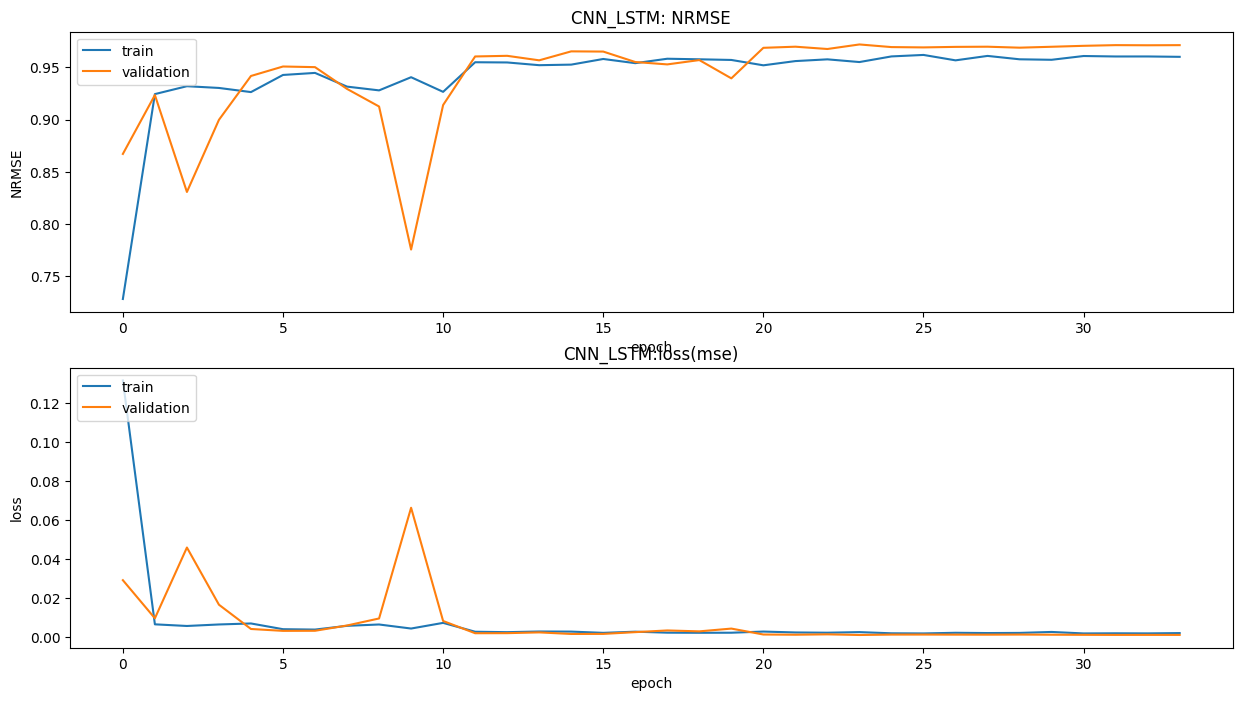

Training model : models/model_LSTM_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM
Epoch 1/200
40/46 [=========================>....] - ETA: 0s - loss: 0.3074 - NRMSE: 0.6909
Epoch 1: val_loss improved from inf to 0.35627, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 3s 52ms/step - loss: 0.2717 - NRMSE: 0.7172 - val_loss: 0.3563 - val_NRMSE: 0.4167 - lr: 0.0500
Epoch 2/200
37/46 [=======================>......] - ETA: 0s - loss: 0.0085 - NRMSE: 0.9109
Epoch 2: val_loss improved from 0.35627 to 0.29762, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 39ms/step - loss: 0.0086 - NRMSE: 0.9107 - val_loss: 0.2976 - val_NRMSE: 0.4690 - lr: 0.0500
Epoch 3/200
39/46 [========================>.....] - ETA: 0s - loss: 0.0085 - NRMSE: 0.9122
Epoch 3: val_loss improved from 0.29762 to 0.20486, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 39ms/step - loss: 0.0080 - NRMSE: 0.9143 - val_loss: 0.2049 - val_NRMSE: 0.5644 - lr: 0.0500
Epoch 4/200
41/46 [=========================>....] - ETA: 0s - loss: 0.0064 - NRMSE: 0.9240
Epoch 4: val_loss improved from 0.20486 to 0.13553, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 47ms/step - loss: 0.0064 - NRMSE: 0.9232 - val_loss: 0.1355 - val_NRMSE: 0.6532 - lr: 0.0500
Epoch 5/200
39/46 [========================>.....] - ETA: 0s - loss: 0.0071 - NRMSE: 0.9198
Epoch 5: val_loss improved from 0.13553 to 0.06904, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 41ms/step - loss: 0.0070 - NRMSE: 0.9201 - val_loss: 0.0690 - val_NRMSE: 0.7659 - lr: 0.0500
Epoch 6/200
45/46 [============================>.] - ETA: 0s - loss: 0.0074 - NRMSE: 0.9185
Epoch 6: val_loss did not improve from 0.06904
46/46 [==============================] - 0s 7ms/step - loss: 0.0073 - NRMSE: 0.9191 - val_loss: 0.1820 - val_NRMSE: 0.5905 - lr: 0.0500
Epoch 7/200
43/46 [===========================>..] - ETA: 0s - loss: 0.0066 - NRMSE: 0.9221
Epoch 7: val_loss did not improve from 0.06904
46/46 [==============================] - 0s 7ms/step - loss: 0.0065 - NRMSE: 0.9227 - val_loss: 0.2366 - val_NRMSE: 0.5273 - lr: 0.0500
Epoch 8/200
46/46 [==============================] - ETA: 0s - loss: 0.0061 - NRMSE: 0.9245
Epoch 8: val_loss did not improve from 0.06904
46/46 [==============================] - 0s 9ms/step - loss: 0.0061 - NRMSE: 0.9245 - val_loss: 0.2713 - val_NRMSE: 0.4926 - lr: 0.0500
Epoch 9/200
45/46 [===================

INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 46ms/step - loss: 0.0056 - NRMSE: 0.9300 - val_loss: 0.0537 - val_NRMSE: 0.7953 - lr: 0.0500
Epoch 11/200
46/46 [==============================] - ETA: 0s - loss: 0.0054 - NRMSE: 0.9305
Epoch 11: val_loss did not improve from 0.05367
46/46 [==============================] - 0s 7ms/step - loss: 0.0054 - NRMSE: 0.9305 - val_loss: 0.1581 - val_NRMSE: 0.6101 - lr: 0.0500
Epoch 12/200
44/46 [===========================>..] - ETA: 0s - loss: 0.0088 - NRMSE: 0.9105
Epoch 12: val_loss did not improve from 0.05367
46/46 [==============================] - 0s 7ms/step - loss: 0.0090 - NRMSE: 0.9096 - val_loss: 0.4272 - val_NRMSE: 0.3483 - lr: 0.0500
Epoch 13/200
41/46 [=========================>....] - ETA: 0s - loss: 0.0068 - NRMSE: 0.9205
Epoch 13: val_loss did not improve from 0.05367
46/46 [==============================] - 0s 8ms/step - loss: 0.0068 - NRMSE: 0.9196 - val_loss: 0.1712 - val_NRMSE: 0.5862 - lr: 0.0500
Epoch 14/200
37/46 [============

INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 42ms/step - loss: 0.0063 - NRMSE: 0.9240 - val_loss: 0.0485 - val_NRMSE: 0.7822 - lr: 0.0500
Epoch 15/200
42/46 [==========================>...] - ETA: 0s - loss: 0.0081 - NRMSE: 0.9139
Epoch 15: val_loss did not improve from 0.04851
46/46 [==============================] - 0s 10ms/step - loss: 0.0079 - NRMSE: 0.9154 - val_loss: 0.1008 - val_NRMSE: 0.6829 - lr: 0.0500
Epoch 16/200
44/46 [===========================>..] - ETA: 0s - loss: 0.0061 - NRMSE: 0.9263
Epoch 16: val_loss improved from 0.04851 to 0.01128, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 53ms/step - loss: 0.0060 - NRMSE: 0.9270 - val_loss: 0.0113 - val_NRMSE: 0.8984 - lr: 0.0500
Epoch 17/200
42/46 [==========================>...] - ETA: 0s - loss: 0.0050 - NRMSE: 0.9310
Epoch 17: val_loss improved from 0.01128 to 0.00406, saving model to models/model_LSTM_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 51ms/step - loss: 0.0050 - NRMSE: 0.9315 - val_loss: 0.0041 - val_NRMSE: 0.9431 - lr: 0.0500
Epoch 18/200
37/46 [=======================>......] - ETA: 0s - loss: 0.0065 - NRMSE: 0.9233
Epoch 18: val_loss did not improve from 0.00406
46/46 [==============================] - 0s 7ms/step - loss: 0.0064 - NRMSE: 0.9255 - val_loss: 0.0072 - val_NRMSE: 0.9301 - lr: 0.0500
Epoch 19/200
42/46 [==========================>...] - ETA: 0s - loss: 0.0044 - NRMSE: 0.9373
Epoch 19: val_loss did not improve from 0.00406
46/46 [==============================] - 0s 8ms/step - loss: 0.0043 - NRMSE: 0.9382 - val_loss: 0.0417 - val_NRMSE: 0.8051 - lr: 0.0500
Epoch 20/200
46/46 [==============================] - ETA: 0s - loss: 0.0065 - NRMSE: 0.9226
Epoch 20: val_loss did not improve from 0.00406
46/46 [==============================] - 0s 7ms/step - loss: 0.0065 - NRMSE: 0.9226 - val_loss: 0.1493 - val_NRMSE: 0.6188 - lr: 0.0500
Epoch 21/200
46/46 [============

INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 40ms/step - loss: 0.0042 - NRMSE: 0.9371 - val_loss: 0.0017 - val_NRMSE: 0.9610 - lr: 0.0100
Epoch 27/200
43/46 [===========================>..] - ETA: 0s - loss: 0.0042 - NRMSE: 0.9381
Epoch 27: val_loss did not improve from 0.00167
46/46 [==============================] - 0s 7ms/step - loss: 0.0041 - NRMSE: 0.9385 - val_loss: 0.0023 - val_NRMSE: 0.9539 - lr: 0.0100
Epoch 28/200
44/46 [===========================>..] - ETA: 0s - loss: 0.0046 - NRMSE: 0.9355
Epoch 28: val_loss did not improve from 0.00167
46/46 [==============================] - 0s 8ms/step - loss: 0.0046 - NRMSE: 0.9353 - val_loss: 0.0026 - val_NRMSE: 0.9534 - lr: 0.0100
Epoch 29/200
38/46 [=======================>......] - ETA: 0s - loss: 0.0035 - NRMSE: 0.9434
Epoch 29: val_loss did not improve from 0.00167
46/46 [==============================] - 0s 7ms/step - loss: 0.0036 - NRMSE: 0.9429 - val_loss: 0.0083 - val_NRMSE: 0.9121 - lr: 0.0100
Epoch 30/200
44/46 [============

INFO:tensorflow:Assets written to: models/model_LSTM_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 43ms/step - loss: 0.0042 - NRMSE: 0.9378 - val_loss: 0.0014 - val_NRMSE: 0.9646 - lr: 0.0100
Epoch 32/200
45/46 [============================>.] - ETA: 0s - loss: 0.0033 - NRMSE: 0.9438
Epoch 32: val_loss did not improve from 0.00140
46/46 [==============================] - 0s 7ms/step - loss: 0.0033 - NRMSE: 0.9440 - val_loss: 0.0081 - val_NRMSE: 0.9159 - lr: 0.0100
Epoch 33/200
44/46 [===========================>..] - ETA: 0s - loss: 0.0037 - NRMSE: 0.9423
Epoch 33: val_loss did not improve from 0.00140
46/46 [==============================] - 0s 7ms/step - loss: 0.0037 - NRMSE: 0.9425 - val_loss: 0.0145 - val_NRMSE: 0.8830 - lr: 0.0100
Epoch 34/200
37/46 [=======================>......] - ETA: 0s - loss: 0.0027 - NRMSE: 0.9484
Epoch 34: val_loss did not improve from 0.00140
46/46 [==============================] - 0s 7ms/step - loss: 0.0031 - NRMSE: 0.9450 - val_loss: 0.0023 - val_NRMSE: 0.9572 - lr: 0.0100
Epoch 35/200
39/46 [============

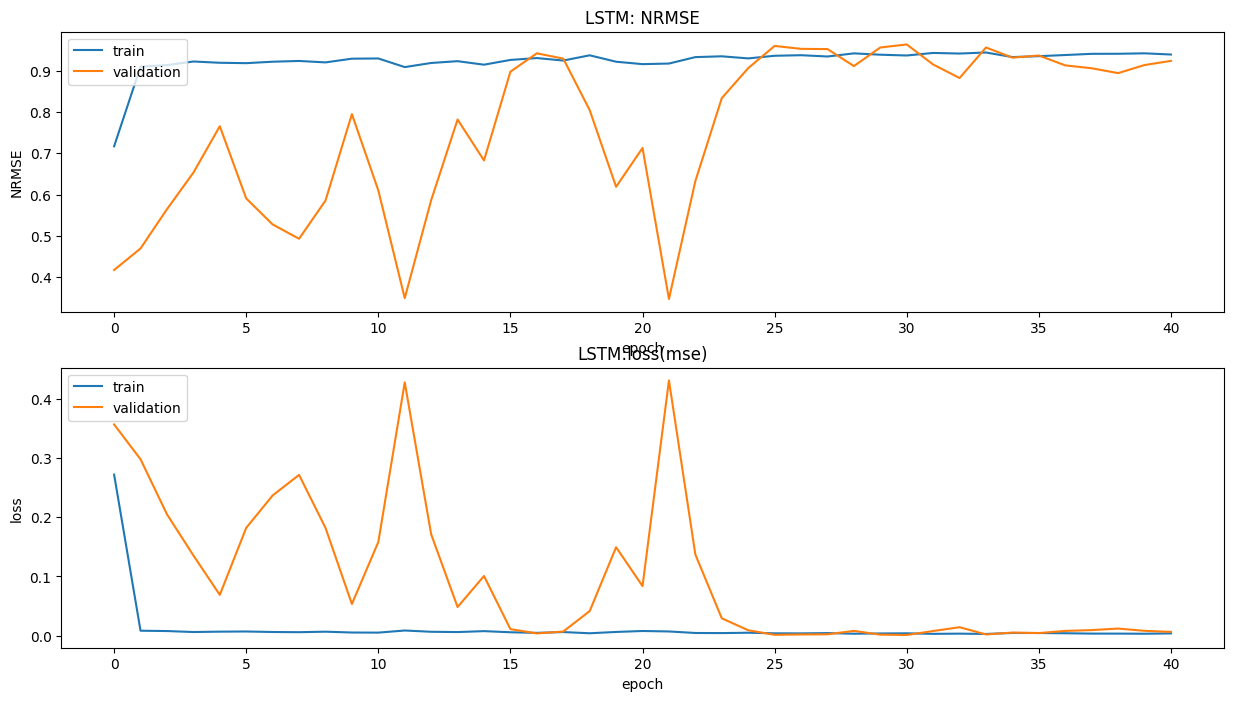

Training model : models/model_LSTM_AT_stock_B3SA3_lookback_23
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Initing train fo model: LSTM_AT
Epoch 1/200
44/46 [===========================>..] - ETA: 0s - loss: 0.5805 - NRMSE: 0.6654
Epoch 1: val_loss improved from inf to 0.08428, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 5s 65ms/step - loss: 0.5618 - NRMSE: 0.6746 - val_loss: 0.0843 - val_NRMSE: 0.7292 - lr: 0.0500
Epoch 2/200
42/46 [==========================>...] - ETA: 0s - loss: 0.0074 - NRMSE: 0.9210
Epoch 2: val_loss did not improve from 0.08428
46/46 [==============================] - 1s 11ms/step - loss: 0.0073 - NRMSE: 0.9205 - val_loss: 0.1171 - val_NRMSE: 0.6710 - lr: 0.0500
Epoch 3/200
43/46 [===========================>..] - ETA: 0s - loss: 0.0046 - NRMSE: 0.9352
Epoch 3: val_loss did not improve from 0.08428
46/46 [==============================] - 0s 10ms/step - loss: 0.0047 - NRMSE: 0.9346 - val_loss: 0.1326 - val_NRMSE: 0.6477 - lr: 0.0500
Epoch 4/200
43/46 [===========================>..] - ETA: 0s - loss: 0.0045 - NRMSE: 0.9383
Epoch 4: val_loss improved from 0.08428 to 0.06282, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 47ms/step - loss: 0.0049 - NRMSE: 0.9353 - val_loss: 0.0628 - val_NRMSE: 0.7623 - lr: 0.0500
Epoch 5/200
42/46 [==========================>...] - ETA: 0s - loss: 0.0035 - NRMSE: 0.9436
Epoch 5: val_loss did not improve from 0.06282
46/46 [==============================] - 0s 9ms/step - loss: 0.0034 - NRMSE: 0.9447 - val_loss: 0.1063 - val_NRMSE: 0.6812 - lr: 0.0500
Epoch 6/200
39/46 [========================>.....] - ETA: 0s - loss: 0.0033 - NRMSE: 0.9450
Epoch 6: val_loss improved from 0.06282 to 0.04531, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 3s 60ms/step - loss: 0.0032 - NRMSE: 0.9460 - val_loss: 0.0453 - val_NRMSE: 0.7980 - lr: 0.0500
Epoch 7/200
46/46 [==============================] - ETA: 0s - loss: 0.0030 - NRMSE: 0.9477
Epoch 7: val_loss improved from 0.04531 to 0.02679, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 43ms/step - loss: 0.0030 - NRMSE: 0.9477 - val_loss: 0.0268 - val_NRMSE: 0.8516 - lr: 0.0500
Epoch 8/200
41/46 [=========================>....] - ETA: 0s - loss: 0.0039 - NRMSE: 0.9413
Epoch 8: val_loss improved from 0.02679 to 0.02201, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 44ms/step - loss: 0.0039 - NRMSE: 0.9412 - val_loss: 0.0220 - val_NRMSE: 0.8658 - lr: 0.0500
Epoch 9/200
42/46 [==========================>...] - ETA: 0s - loss: 0.0034 - NRMSE: 0.9448
Epoch 9: val_loss did not improve from 0.02201
46/46 [==============================] - 0s 9ms/step - loss: 0.0033 - NRMSE: 0.9456 - val_loss: 0.0443 - val_NRMSE: 0.7964 - lr: 0.0500
Epoch 10/200
42/46 [==========================>...] - ETA: 0s - loss: 0.0030 - NRMSE: 0.9485
Epoch 10: val_loss did not improve from 0.02201
46/46 [==============================] - 0s 9ms/step - loss: 0.0032 - NRMSE: 0.9468 - val_loss: 0.0314 - val_NRMSE: 0.8293 - lr: 0.0500
Epoch 11/200
44/46 [===========================>..] - ETA: 0s - loss: 0.0059 - NRMSE: 0.9297
Epoch 11: val_loss did not improve from 0.02201
46/46 [==============================] - 0s 9ms/step - loss: 0.0059 - NRMSE: 0.9296 - val_loss: 0.0421 - val_NRMSE: 0.7968 - lr: 0.0500
Epoch 12/200
42/46 [==============

INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 53ms/step - loss: 0.0026 - NRMSE: 0.9507 - val_loss: 0.0044 - val_NRMSE: 0.9392 - lr: 0.0500
Epoch 13/200
44/46 [===========================>..] - ETA: 0s - loss: 0.0037 - NRMSE: 0.9441
Epoch 13: val_loss improved from 0.00444 to 0.00262, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 43ms/step - loss: 0.0039 - NRMSE: 0.9421 - val_loss: 0.0026 - val_NRMSE: 0.9517 - lr: 0.0500
Epoch 14/200
41/46 [=========================>....] - ETA: 0s - loss: 0.0036 - NRMSE: 0.9451
Epoch 14: val_loss did not improve from 0.00262
46/46 [==============================] - 0s 8ms/step - loss: 0.0034 - NRMSE: 0.9468 - val_loss: 0.0145 - val_NRMSE: 0.8846 - lr: 0.0500
Epoch 15/200
41/46 [=========================>....] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9554
Epoch 15: val_loss did not improve from 0.00262
46/46 [==============================] - 0s 8ms/step - loss: 0.0023 - NRMSE: 0.9550 - val_loss: 0.0276 - val_NRMSE: 0.8372 - lr: 0.0500
Epoch 16/200
46/46 [==============================] - ETA: 0s - loss: 0.0029 - NRMSE: 0.9495
Epoch 16: val_loss improved from 0.00262 to 0.00208, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 49ms/step - loss: 0.0029 - NRMSE: 0.9495 - val_loss: 0.0021 - val_NRMSE: 0.9566 - lr: 0.0500
Epoch 17/200
41/46 [=========================>....] - ETA: 0s - loss: 0.0020 - NRMSE: 0.9570
Epoch 17: val_loss did not improve from 0.00208
46/46 [==============================] - 0s 8ms/step - loss: 0.0020 - NRMSE: 0.9565 - val_loss: 0.0060 - val_NRMSE: 0.9253 - lr: 0.0500
Epoch 18/200
45/46 [============================>.] - ETA: 0s - loss: 0.0031 - NRMSE: 0.9470
Epoch 18: val_loss did not improve from 0.00208
46/46 [==============================] - 0s 9ms/step - loss: 0.0031 - NRMSE: 0.9474 - val_loss: 0.0041 - val_NRMSE: 0.9390 - lr: 0.0500
Epoch 19/200
44/46 [===========================>..] - ETA: 0s - loss: 0.0023 - NRMSE: 0.9549
Epoch 19: val_loss did not improve from 0.00208
46/46 [==============================] - 0s 9ms/step - loss: 0.0023 - NRMSE: 0.9546 - val_loss: 0.0049 - val_NRMSE: 0.9351 - lr: 0.0500
Epoch 20/200
40/46 [============

INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 41ms/step - loss: 0.0013 - NRMSE: 0.9658 - val_loss: 0.0017 - val_NRMSE: 0.9605 - lr: 0.0100
Epoch 25/200
41/46 [=========================>....] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9645
Epoch 25: val_loss improved from 0.00167 to 0.00166, saving model to models/model_LSTM_AT_stock_B3SA3_lookback_23
INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


INFO:tensorflow:Assets written to: models/model_LSTM_AT_stock_B3SA3_lookback_23/assets


46/46 [==============================] - 2s 41ms/step - loss: 0.0014 - NRMSE: 0.9642 - val_loss: 0.0017 - val_NRMSE: 0.9606 - lr: 0.0100
Epoch 26/200
41/46 [=========================>....] - ETA: 0s - loss: 0.0014 - NRMSE: 0.9630
Epoch 26: val_loss did not improve from 0.00166
46/46 [==============================] - 0s 9ms/step - loss: 0.0014 - NRMSE: 0.9631 - val_loss: 0.0017 - val_NRMSE: 0.9605 - lr: 0.0100
Epoch 27/200
39/46 [========================>.....] - ETA: 0s - loss: 0.0016 - NRMSE: 0.9619
Epoch 27: val_loss did not improve from 0.00166
46/46 [==============================] - 0s 8ms/step - loss: 0.0016 - NRMSE: 0.9605 - val_loss: 0.0017 - val_NRMSE: 0.9606 - lr: 0.0100
Epoch 28/200
46/46 [==============================] - ETA: 0s - loss: 0.0015 - NRMSE: 0.9629
Epoch 28: val_loss did not improve from 0.00166
46/46 [==============================] - 0s 8ms/step - loss: 0.0015 - NRMSE: 0.9629 - val_loss: 0.0019 - val_NRMSE: 0.9587 - lr: 0.0100
Epoch 29/200
41/46 [============

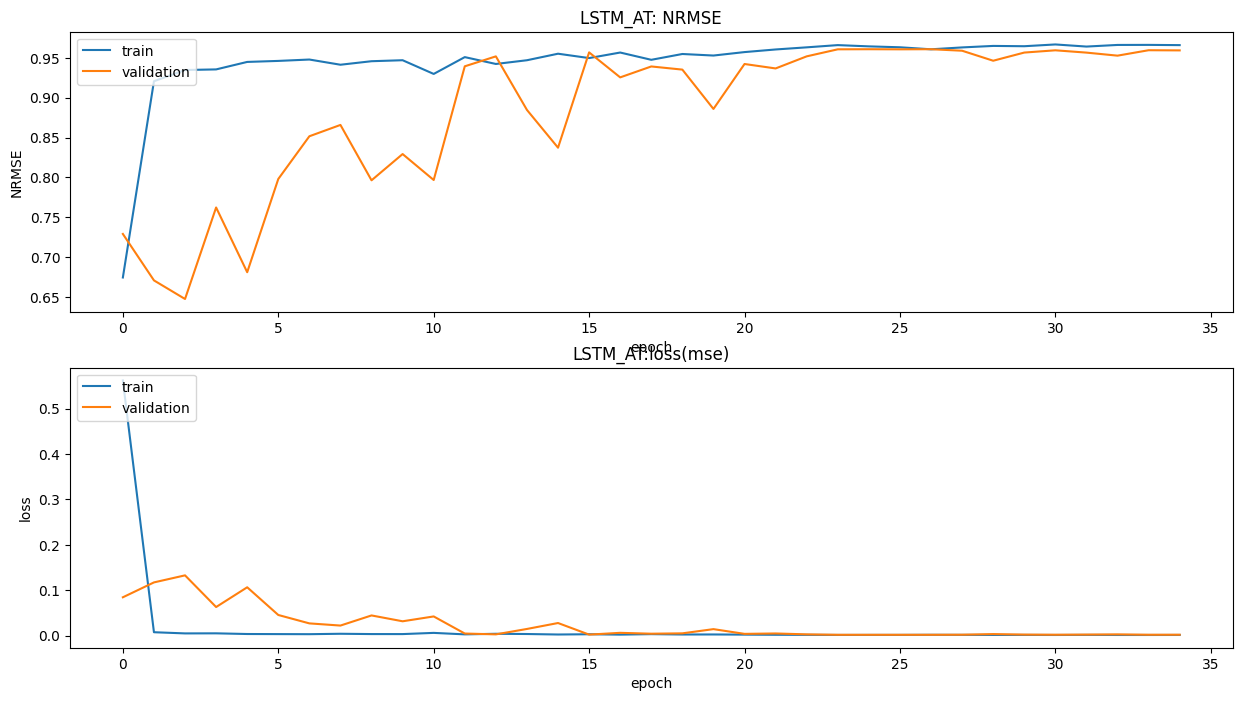

In [41]:
list_of_models=[model_MLP, model_GRU, model_CNN_LSTM, model_LSTM, model_LSTM_AT]
#list_of_models=[model_LSTM, model_LSTM_AT, model_GRU ]

for model in list_of_models:  
    optimizer = get_optimizer()
    csvLogger, model_checkpoint_callback  = checkpoints(model._name)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[NRMSE])

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print(f'Initing train fo model: {model._name}')
    history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=32, shuffle=True, validation_split=0.3 ,callbacks=[EarlyStopping, reduceLr, model_checkpoint_callback,csvLogger])

    history_metric=np.array(history.history['NRMSE']) 
    history_metric_val=np.array(history.history['val_NRMSE'])  

    plt.figure(1,figsize=(15,8))  
    # summarize history for accuracy  
    plt.subplot(211)  
    plt.plot(history_metric[history_metric>0]) 
    plt.plot(history_metric_val[history_metric_val>0])  
    plt.title(f'{model._name}: NRMSE')  
    plt.ylabel('NRMSE')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left') 
    # summarize history for loss  
    plt.subplot(212)  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])   
    plt.title(f'{model._name}:loss(mse)')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()  
    #history=model.fit( x=X_train, y=y_train, epochs=200, batch_size=256, shuffle=True, validation_split=0.1, callbacks=[EarlyStopping,model_checkpoint_callback, reduceLr])

### Validation

In [42]:
# carrega os modelos terinados
from tensorflow import keras
trained_best_models={}
for model in list_of_models:
    checkpoint_filepath =f'models/model_{model._name}_stock_{ticker}_lookback_{lookback}'
    trained_best_models[f'{model._name}']=keras.models.load_model(checkpoint_filepath, custom_objects={'NRMSE':NRMSE})

In [43]:
checkpoint_filepath

'models/model_LSTM_AT_stock_B3SA3_lookback_23'

In [44]:
trained_best_models

{'MLP': <keras.src.engine.functional.Functional at 0x7f246428dea0>,
 'GRU': <keras.src.engine.functional.Functional at 0x7f243735fa90>,
 'CNN_LSTM': <keras.src.engine.sequential.Sequential at 0x7f24640fce50>,
 'LSTM': <keras.src.engine.functional.Functional at 0x7f24c5735870>,
 'LSTM_AT': <keras.src.engine.functional.Functional at 0x7f24655cb010>}

In [45]:
def R2(y_true, y_pred): # squareds Pearson's correlation coef 
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot) )

X_real, y_real = windowing(df,features_indicators)

for idx in range(len(features_indicators)+lookback):
    X_real[:,idx]=np.squeeze(scaler.transform(X_real[:,idx].reshape(-1,1)))
#X_real=features_scaler.transform(X_real)
#y_real=scaler.transform(y_real)
#X_real=features_scaler(X_real)

#do the smae split data with the original data to compare 
X_train_real,X_test_real, y_train_real, y_test_real,T_train,_=split_data(X_real,y_real,date_time, factor=0.85)

predictions=[]
for model_name in trained_best_models:
    y_pred=scaler.inverse_transform(trained_best_models[model_name].predict(X_test))
    r2_score= R2(y_test_real, y_pred )
    print(model_name,'NN R2:', r2_score)

    predictions+=[y_pred]
predictions=np.hstack(predictions)

12/12 [==============================] - 0s 744us/step
MLP NN R2: 0.9149585937704725
12/12 [==============================] - 0s 2ms/step
GRU NN R2: 0.9227458428369801
12/12 [==============================] - 0s 819us/step
CNN_LSTM NN R2: 0.9107466323402981
12/12 [==============================] - 0s 2ms/step
LSTM NN R2: 0.8851147789615434
12/12 [==============================] - 0s 3ms/step
LSTM_AT NN R2: 0.8534536906716147


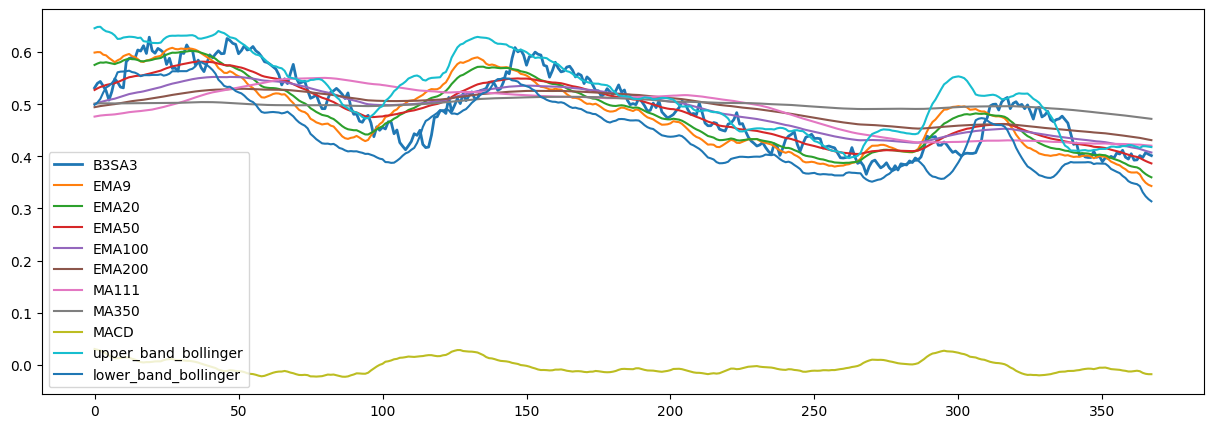

In [46]:
plt.figure(figsize=(15,5))
plt.plot(X_test[:,0],label=ticker,linewidth=2)
plt.plot(X_test[:,-len(features_indicators):])
plt.legend([ticker]+features_indicators)
plt.show()

In [47]:
y_test_real=np.hstack(y_test_real)
y_pred=np.hstack(y_pred)
y_train_real=np.hstack(y_train_real)

In [48]:
trained_best_models.keys()

dict_keys(['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT'])

In [49]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

# Adiciona os valores reais ao gráfico
#fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name='Real', line=dict(color='red')))
fig.add_trace(go.Scatter(x=T_train, y=y_train_real, mode='lines',name="Dados de Treino",line=dict(color='black')))
fig.add_trace(go.Scatter(x=T_test, y=y_test_real, mode='lines', name="Dados de Teste", line=dict(color='red')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'yellow', 'violet', 'yellowgreen', 'green']
for i in range(predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_test, y=predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))

# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()


### Get new values to future prediction 

In [50]:
dias_antes=1
n_steps=7

print("Temos dados até o dia :",T_test.iloc[-1].date())

print("Estamos Fornecendo dados até o dia :",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes))

print("O modelo fará previsões até o dia: ",T_test.iloc[-1].date() -datetime.timedelta(days=dias_antes) + datetime.timedelta(days=n_steps))

Temos dados até o dia : 2024-12-04
Estamos Fornecendo dados até o dia : 2024-12-03
O modelo fará previsões até o dia:  2024-12-10


In [51]:
new_predictions=[]
for model in list_of_models:
    # processo interativo para predição com o modelo de rede neural
    dias_antes=1
    n_steps=5

    if dias_antes == 0:
        NN_predictions=y_test.copy()
        # normalized data
        X_inputs=comput_features(scaler.transform(y_test_real.reshape(-1,1)),lookback, features_indicators).reshape(1,-1)
        #X_inputs=X_test.copy()
        
        T_preds=T_test.values.copy()
    else :
        NN_predictions=y_test[:-dias_antes].copy()
    
        X_inputs=comput_features(scaler.transform(y_test_real.reshape(-1,1))[:-dias_antes,:],lookback, features_indicators).reshape(1,-1)

        #X_inputs=X_test[:-dias_antes,:].copy()
        T_preds=T_test.values[:-dias_antes].copy()
    continuous_time=T_preds.copy()
    
    for k in range(n_steps):
        # normalzação das features
        #for idx in range(len(features_indicators)+lookback):
        #    X_inputs[-1,idx]=np.squeeze(scaler.transform(X_inputs[-1,idx].reshape(-1,1)))
        

        # realizar a predição interativa com o modelo
        y_pred=model.predict(X_inputs[-1,:].reshape(1,-1))

        # guarda a predição do modelo para usa-la como entrada para a proxima predição
        NN_predictions=np.append(NN_predictions,[y_pred[0][0]])
        X_inputs=np.append(X_inputs,comput_features(NN_predictions,lookback, features_indicators).reshape(1,-1),axis=0)

        
        #X_inputs=np.append(X_inputs,NN_predictions[-lookback:].reshape(1,-1),axis=0)

        # acrescenta um dia ao tempo atual 
        next_day=continuous_time[-1]+np.timedelta64(1,'D')
        continuous_time=np.append(continuous_time,next_day)    
        # verifica se o próximo dia é final de semana, se for pula até o dia útil 
        while next_day.astype('datetime64[D]').astype(datetime.datetime).isoweekday() > 5:
            # acrescenta um dia ao tempo atual 
            next_day=continuous_time[-1]+np.timedelta64(1,'D')
            continuous_time=np.append(continuous_time,next_day)

        T_preds=np.append(T_preds,next_day)
        
    new_predictions+=[scaler.inverse_transform(NN_predictions.reshape(-1,1))]
new_predictions=np.hstack(new_predictions)

1/1 [==============================] - 0s 11ms/step


In [52]:
# ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

combined_data_train=np.append(y_train,y_test[:-dias_antes])

try:
    if model_arima_fit is not None:
        print('Using ARIMA model')
except:
    model_arima = ARIMA(combined_data_train, order=(30, 2, 7))
    model_arima_fit = model_arima.fit()

    arima_predictions = model_arima_fit.predict(start=len(combined_data_train), end=len(combined_data_train)+n_steps)
    arima_predictions=np.hstack(scaler.inverse_transform(arima_predictions.reshape(-1,1)))
    arima_predictions.shape

/home/bruno.dutra/Bruno/time_series_forecast/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/bruno.dutra/Bruno/time_series_forecast/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/bruno.dutra/Bruno/time_series_forecast/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [53]:
import plotly.graph_objects as go

# Cria um gráfico de linha usando o Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=T_preds[-(n_steps+1):], y=arima_predictions, mode='lines', name="Predicted ARIMA", line=dict(color='green')))

# Adiciona os valores preditos ao gráfico
colors=['blue', 'tomato', 'violet', 'yellowgreen', 'green']
for i in range(new_predictions.shape[1]):
    fig.add_trace(go.Scatter(x=T_preds, y=new_predictions[:,i], mode='lines', name=f'{list(trained_best_models.keys())[i]}', line=dict(color=colors[i])))


# Adiciona os valores reais ao gráfico
fig.add_trace(go.Scatter(x=T_test.values, y=y_test_real, mode='lines', name=ticker, line=dict(color='black')))
# Configura o layout do gráfico
fig.update_layout(
    title=f'Resultado da predição com o modelo {model_name}',
    xaxis_title='Data',
    yaxis_title='Valor',
    showlegend=True,
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)')
)

# Exibe o gráfico
fig.show()

In [54]:
# modelos treinados 
[model.name for model in list_of_models]

['MLP', 'GRU', 'CNN_LSTM', 'LSTM', 'LSTM_AT']

In [55]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')

pred_data_df=pd.DataFrame({'Data': T_preds, 'pred': new_predictions[:,model_idx]})
# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100

# Definir a variável alvo com base na variação percentual
pred_data_df['Subida'] = pred_data_df['Variacao'].apply(lambda x: 1 if x > 0.02 else 0)
pred_data_df.tail(10)

Data      pred  Variacao  Subida
362 2024-11-27  9.760000 -4.303279       0
363 2024-11-28  9.150000 -6.666674       0
364 2024-11-29  9.260000  1.187912       1
365 2024-12-02  9.370000  1.173956       1
366 2024-12-03  9.460000  0.951376       1
367 2024-12-04  9.583857  1.292352       1
368 2024-12-05  9.677955  0.972286       1
369 2024-12-06  9.678932  0.010101       0
370 2024-12-09  9.647452 -0.326310       0
371 2024-12-10  9.578601 -0.718795       0

In [56]:
pred_data_df[pred_data_df['Data']==df['Date'].iloc[-1]]

Data      pred  Variacao  Subida
367 2024-12-04  9.583857  1.292352       1

In [57]:
result=pred_data_df.iloc[-1:,:]
result

Data      pred  Variacao  Subida
371 2024-12-10  9.578601 -0.718795       0

In [58]:
print("A previsão para o dia", result['Data'].item().date(),
      "é de", 'subida,' if result['Subida'].values==1 else "Descida,",
      f"de {np.round(result['Variacao'].values[0],2)}%",
      "o valor predito é de:", np.round(result['pred'].values[0],2) )

A previsão para o dia 2024-12-10 é de Descida, de -0.72% o valor predito é de: 9.58


In [59]:
comput_features(y_test, lookback, features_indicators).reshape(1,-1)

array([[ 0.39330833,  0.38306593,  0.4055992 ,  0.41123256,  0.39484468,
         0.39791742,  0.37743263,  0.3697508 ,  0.37743263,  0.37333562,
         0.37538415,  0.36155688,  0.36258114,  0.3523387 ,  0.36258114,
         0.36872658,  0.37077506,  0.34926601,  0.31802664,  0.32365999,
         0.3292933 ,  0.33390239,  0.33543874,  0.34157614,  0.35750839,
         0.38454658,  0.4060075 ,  0.42858435,  0.42022002,  0.4713262 ,
        -0.01793646,  0.41249893,  0.31204878]])

In [60]:
model_idx=[model.name for model in list_of_models].index('CNN_LSTM')
model=list_of_models[model_idx]
X_features=comput_features(y_test, lookback, features_indicators).reshape(1,-1)
scaler.inverse_transform(model.predict(X_features))

1/1 [==============================] - 0s 16ms/step


array([[9.637409]], dtype=float32)